In [1]:
from itertools import product
import numpy as np
import scipy
import os
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, pairwise_distances
from sklearn.model_selection import train_test_split, KFold
from scipy.io.arff import loadarff 
import time
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
np.random.seed(42)

In [2]:
data = np.load('qm9_coulomb_matrix.npz', allow_pickle=True)
features = data['features']
labels = data['labels']

indices = list(range(len(features)))
np.random.shuffle(indices)

features = features[indices]
labels = labels[indices]

In [3]:
class RandomFourierFeatures:
    def __init__(self, input_dim, num_features, sigma):
        """
        Initialize the RFF transformer.
        
        Parameters:
        - input_dim: Dimensionality of the input features.
        - num_features: Number of random Fourier features (D).
        - sigma: Kernel bandwidth (scale parameter for Gaussian kernel).
        """
        self.num_features = num_features
        self.sigma = sigma
        self.W = np.random.normal(loc=0, scale=1/sigma, size=(input_dim, num_features))
        self.b = np.random.uniform(0, 2 * np.pi, size=num_features)
    
    def transform(self, X):
        """
        Transform the input features to the RFF feature space.
        
        Parameters:
        - X: Input features, shape (n_samples, input_dim).
        
        Returns:
        - Transformed features, shape (n_samples, num_features).
        """
        projection = X @ self.W + self.b
        return np.sqrt(2 / self.num_features) * np.cos(projection)


In [4]:
def KRR_with_RFF(X_train, y_train, X_test, lam, sigma, num_features=500):
    """
    Kernel Ridge Regression using Random Fourier Features (RFF).
    
    Parameters:
    - X_train: Training data, shape (n_train, input_dim).
    - y_train: Training labels, shape (n_train,).
    - X_test: Test data, shape (n_test, input_dim).
    - lam: Regularization parameter (lambda).
    - sigma: Bandwidth for the Gaussian kernel.
    - num_features: Number of random Fourier features to generate.
    
    Returns:
    - Predictions on the test data.
    """
    # Transform features using RFF
    rff = RandomFourierFeatures(input_dim=X_train.shape[1], num_features=num_features, sigma=sigma)
    X_train_rff = rff.transform(X_train)
    X_test_rff = rff.transform(X_test)
    
    # Ridge regression in transformed space
    K = X_train_rff.T @ X_train_rff + lam * np.eye(num_features)
    alphas = np.linalg.solve(K, X_train_rff.T @ y_train)
    
    # Predictions
    y_pred = X_test_rff @ alphas
    return y_pred

def KRR(X_train, y_train, X_test, lam, sigma):
    """
    Kernel Ridge Regression using Random Fourier Features (RFF). << not using RFF?
    
    Parameters:
    - X_train: Training data, shape (n_train, input_dim).
    - y_train: Training labels, shape (n_train,).
    - X_test: Test data, shape (n_test, input_dim).
    - lam: Regularization parameter (lambda).
    - sigma: Bandwidth for the Gaussian kernel.
    - num_features: Number of random Fourier features to generate.
    
    Returns:
    - Predictions on the test data.
    """
    dist = pairwise_distances(X_train)
    exponent = dist/sigma

    K = np.exp(-(exponent**2)/2)
    K += np.eye(K.shape[0])*lam
    
    alphas = np.linalg.solve(K, y_train)
    dist = scipy.spatial.distance_matrix(X_train, X_test)
    exponent = dist/sigma

    K_test = np.exp(-(exponent**2)/2)

    # Predictions
    y_pred = K_test.T @ alphas
    
    return y_pred

def GridSearchCV(X, Y, params, cv=4, train_set_ratio=1): # finds best lamba & sigma for given percentage of train data
    print(params)
    kf = KFold(n_splits=cv)
    X_train, X_test = [], []
    Y_train, Y_test = [], []
    for train, test in kf.split(X):
        train_size = int(train_set_ratio*len(train))
        sampled_train = np.random.choice(train, train_size, replace=False)
        X_train.append(X[sampled_train])
        Y_train.append(Y[sampled_train])
        X_test.append(X[test])
        Y_test.append(Y[test])

    best_score = np.inf  # Maximizing accuracy
    for lam, sigma in product(params['lambda'], params['length']):
        print(lam,sigma)
        maes = []
        for k in range(cv):
            preds = KRR(X_train[k], Y_train[k], X_test[k], lam, sigma)
            if type(preds) == str:
                accuracy = 0
            else:
                
                mae = np.mean(np.abs(preds - Y_test[k]))
                maes.append(mae)
        mean_accuracy = np.mean(maes)
        print(mean_accuracy)
        if mean_accuracy < best_score:
            best_score = mean_accuracy
            best_lambda = lam
            best_sigma = sigma
    
    return {'accuracy': best_score, 'lambda': best_lambda, 'length': best_sigma}

## Functions for feature number sweep

In [74]:
def GridSearchFeature(X,Y, params, num_features,cv=4):
    """
    Finds best lamba & sigma for given percentage number of features.
    - num_features: array of features to try the regression
    """
    lambdas = params['lambdas']
    sigmas = params['sigmas']
    kf = KFold(n_splits=cv)
    X_train, X_val = [], []
    Y_train, Y_val = [], []
    for train, val in kf.split(X):
        X_train.append(X[train])
        Y_train.append(Y[train])
        X_val.append(X[val])
        Y_val.append(Y[val])
    best_scores = np.full((num_features.shape[0],), np.inf, dtype=np.float32)
    best_lambdas = np.zeros((num_features.shape[0],))
    best_sigmas = np.zeros((num_features.shape[0],))
    score_matrix = np.full((num_features.shape[0], len(lambdas), len(sigmas)), np.inf, dtype=np.float32) # store loss of grid
    
    for i, num_feature in enumerate(num_features):
        best_score = np.inf  # minimize the loss 
        for l, lam in enumerate(lambdas):
            for s, sig in enumerate(sigmas):
                maes = []
                for k in range(cv):
                    preds = KRR_with_RFF(X_train[k], Y_train[k], X_val[k], lam, sig, num_feature)
                    if type(preds) == str:
                        mae = np.inf # we should not be here
                    else:
                        mae = np.mean(np.abs(preds - Y_val[k]))
                        maes.append(mae)
                mean_loss = np.mean(maes)
                # print(mean_loss)
                score_matrix[i,l,s] = mean_loss
                if mean_loss < best_score:
                    best_score = mean_loss
                    best_lambda = lam
                    best_sigma = sig
        # store best _score, _lambda, _sigma for the corresponding features
        best_scores[i] = best_score
        best_lambdas[i] = best_lambda
        best_sigmas[i] = best_sigma

    return score_matrix, best_scores, best_lambdas, best_sigmas,  num_features


def plot_grid(num_features, score_matrix, lambdas): # score_matrix should be 3-dimensional (features, lambdas, sigmas)
    for i, num_feature in enumerate(num_features):
        # Use LateX for text rendering
        plt.rc('text', usetex=False) # usetex = True
        plt.figure(figsize=(10, 8))
        plt.imshow(score_matrix[i,:,:], cmap="viridis_r", interpolation="nearest")
        plt.colorbar(label="loss")
        # plt.xticks(range(len(sigmas_unique)), sigmas_unique, rotation=45)
        plt.xticks([0, 5, 10], [1, 100, 10000]) # Only show 1, 100, 10000 for sigma
        plt.yticks(range(len(lambdas)), lambdas)
        plt.xlabel("$\sigma$", fontsize=14)
        plt.ylabel("$\lambda$", fontsize=14)
        plt.title(f"Grid Search Loss Heatmap for n = {num_feature}", fontsize=16)
        plt.savefig(f"feature_sweep_results/Loss Heatmap for n = {num_feature}")
        plt.show()


def mae_across_feature(X, Y, X_test, Y_test, best_lambdas, best_sigmas, num_features, cv=4): # 
    kf = KFold(n_splits=cv)
    X_train, Y_train = [], []
    for train, _ in kf.split(X):
        X_train.append(X[train])
        Y_train.append(Y[train])
    mean_losses = np.full((num_features.shape[0],), np.inf, dtype=np.float32)
    for i, num_feature in enumerate(num_features):
        maes = []
        lam = best_lambdas[i]
        sig = best_sigmas[i]
        for k in range(cv):
            preds = KRR_with_RFF(X_train[k], Y_train[k], X_test, lam, sig, num_feature)
            if type(preds) == str:
                mae = np.inf # we should not be here
            else:
                mae = np.mean(np.abs(preds - Y_test))
                maes.append(mae)
        mean_losses[i] = np.mean(maes)

    return mean_losses


def plot_feature_sweep(mean_losses, num_features):
    # Apply unit conversion 
    mean_losses_converted = mean_losses * 627.5

    # plot best loss through the feature size
    plt.rc('text', usetex=False) #usetex=True
    plt.figure(figsize=(8, 6))
    plt.plot(num_features, mean_losses_converted, marker='o')
    plt.xlabel("Number of Features", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.title("Loss vs. Number of Random Fourier Features", fontsize=16)
    plt.grid(True)
    plt.savefig('feature_sweep_results/loss_vs_num_features.png')
    plt.show()

    plt.rc('text', usetex=False) #usetex=True
    plt.figure(figsize=(8, 6))
    plt.plot(num_features, mean_losses_converted, marker='o')
    plt.xlabel("Number of Features", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.title("Loss vs. Number of Random Fourier Features", fontsize=16)
    plt.grid(True)
    plt.yscale('log') 
    plt.xscale('log')
    plt.savefig('feature_sweep_results/loss_vs_num_features_loglog.png')
    plt.show() 

    # plot best loss through the feature size
    plt.rc('text', usetex=False) #usetex=True
    plt.figure(figsize=(8, 6))
    plt.plot(num_features, mean_losses, marker='o')
    plt.xlabel("Number of Features", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.title("Loss vs. Number of Random Fourier Features", fontsize=16)
    plt.grid(True)
    plt.savefig('feature_sweep_results/loss_vs_num_features_atomic.png')
    plt.show()

    plt.rc('text', usetex=False) #usetex=True
    plt.figure(figsize=(8, 6))
    plt.plot(num_features, mean_losses, marker='o')
    plt.xlabel("Number of Features", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.title("Loss vs. Number of Random Fourier Features", fontsize=16)
    plt.grid(True)
    plt.yscale('log') 
    plt.xscale('log')
    plt.savefig('feature_sweep_results/loss_vs_num_features_atomic_loglog.png')
    plt.show() 
 





<>:58: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\l'
<>:58: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\l'
/var/folders/hf/xpg67mrx1vjb7hzv3ym5m07c0000gn/T/ipykernel_57079/607099116.py:58: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$\sigma$", fontsize=14)
/var/folders/hf/xpg67mrx1vjb7hzv3ym5m07c0000gn/T/ipykernel_57079/607099116.py:59: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\lambda$", fontsize=14)


In [72]:
# learning curve for various number of train samples
from math import floor
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, r2_score
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)


def RFF_fraction_experiment(X,Y,X_test,Y_test, best_lambdas, best_sigmas, num_features, fraction, cv=4):
    """
    Plots metrics (MAE and R2_score) for different training set size and number of random features    
    """
    kf = KFold(n_splits=cv)
    # 
    X_train, Y_train = [], []
    for train, _ in kf.split(X):
        X_train.append(X[train])
        Y_train.append(Y[train])
    maes = np.full((cv, num_features.shape[0], fraction.shape[0]), np.inf, dtype=np.float32)
    r2_scores = np.zeros((cv, num_features.shape[0], fraction.shape[0]))
    for i in range(cv):
        for j, num_feature in enumerate(num_features):
            for k, frac in enumerate(fraction):
                N = floor(X_train[i].shape[0] * frac)
                x_frac = X_train[i][:N]
                y_frac = Y_train[i][:N]
                lam = best_lambdas[j]
                sig = best_sigmas[j]
                preds = KRR_with_RFF(x_frac, y_frac, X_test, lam, sig, num_feature)
                if type(preds) == str:
                    continue
                else:
                    maes[i,j,k] = np.mean(np.abs(preds - Y_test))
                    r2_scores[i,j,k] = r2_score(Y_test, preds)
    
    # calculate mean across k-folds
    maes = maes.mean(axis=0) * 627.5 # conversion for human 
    r2_scores = r2_scores.mean(axis=0) 
    fraction = fraction * 100 # conversion to percent

    return maes, r2_scores


def plot_fraction_exp(maes, r2_scores, num_features, fraction):
    # plot the curve
    fraction = fraction*100 # decimal to percent conversion
    fig, axs = plt.subplots(1,2, figsize=(10,5), tight_layout=True)
    fig.suptitle("Metrics vs. Percentage of training sample used to build Kernel", fontsize=20)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel("Percentage of Training set")
    axs[0].set_ylabel("Mean Absolute Loss")
    axs[0].grid()
    axs[1].set_xlabel("Percentage of Training set")
    axs[1].set_ylabel("Mean R2 Score")
    axs[1].grid()
    labels = []
    for i, n in enumerate(num_features):
        axs[0].plot(fraction, maes[i,:], marker='o')
        axs[1].plot(fraction, r2_scores[i,:], marker='o')
        labels.append(n)
    axs[1].legend(["n="+str(n) for n in labels])
    fig.savefig('krr_fraction_experiment/rff_metrics.png')
    fig.show()



  0%|          | 0/5 [00:00<?, ?it/s]

Grid Search | Feature Sweep | Fraction Experiment
Grid Search | Feature Sweep | Fraction Experiment
Grid Search | Feature Sweep | Fraction Experiment
Grid Search | Feature Sweep | Fraction Experiment
Grid Search | Feature Sweep | Fraction Experiment


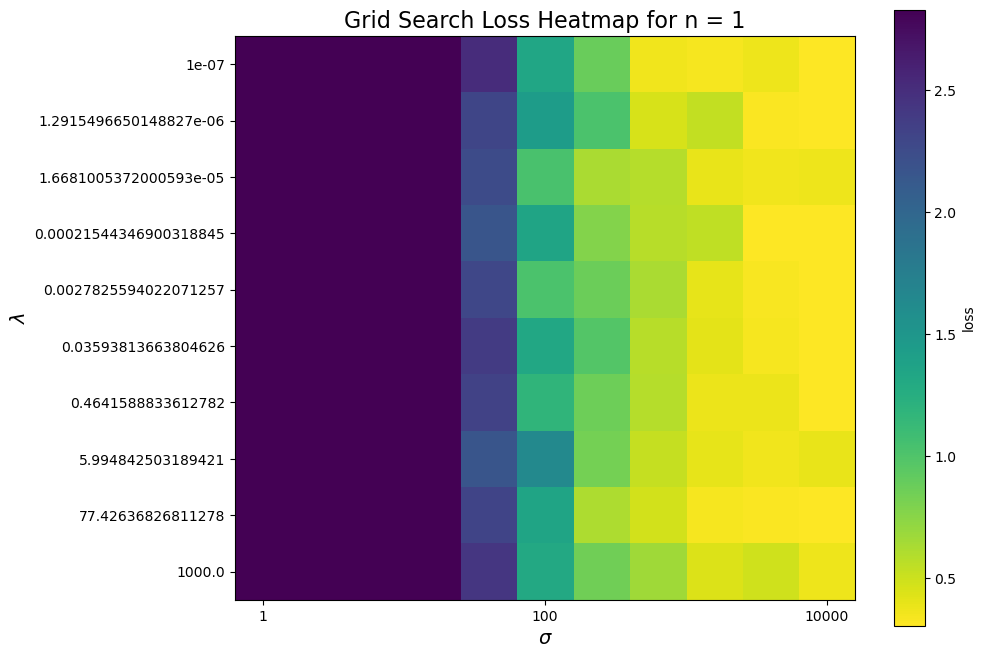

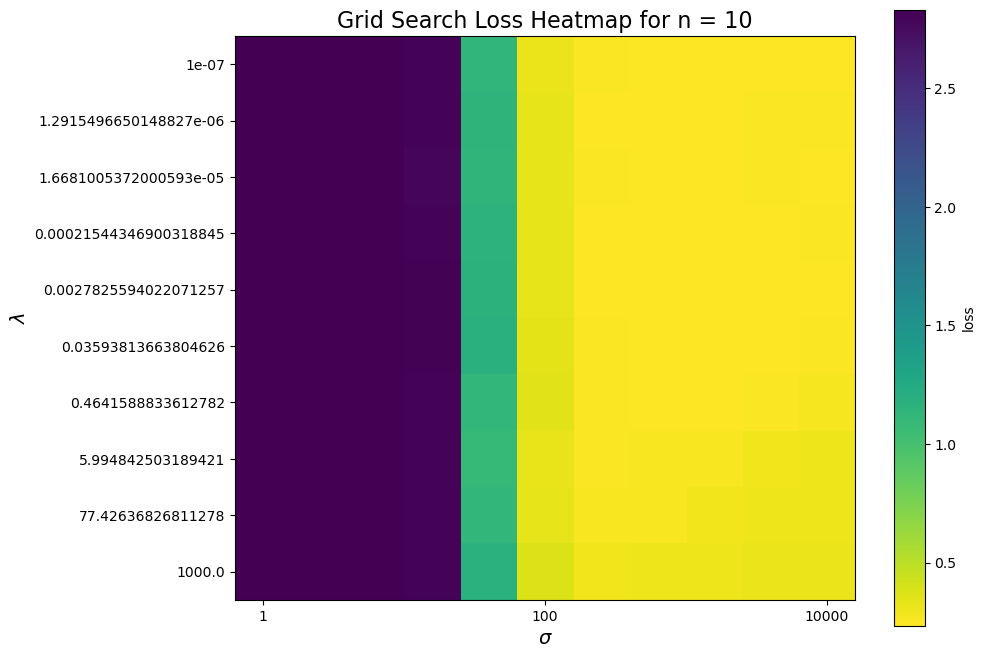

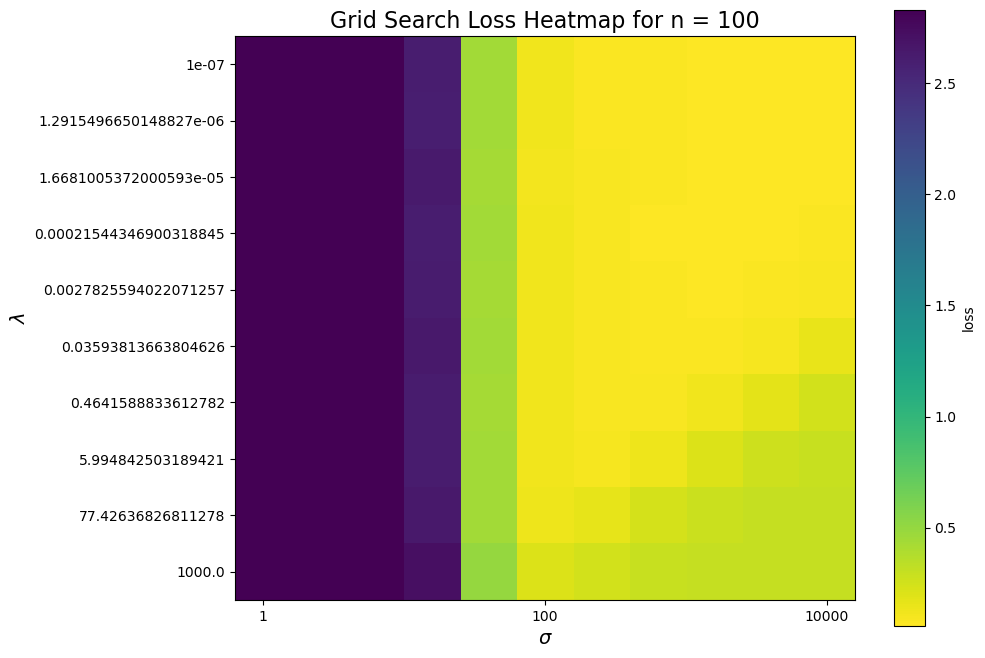

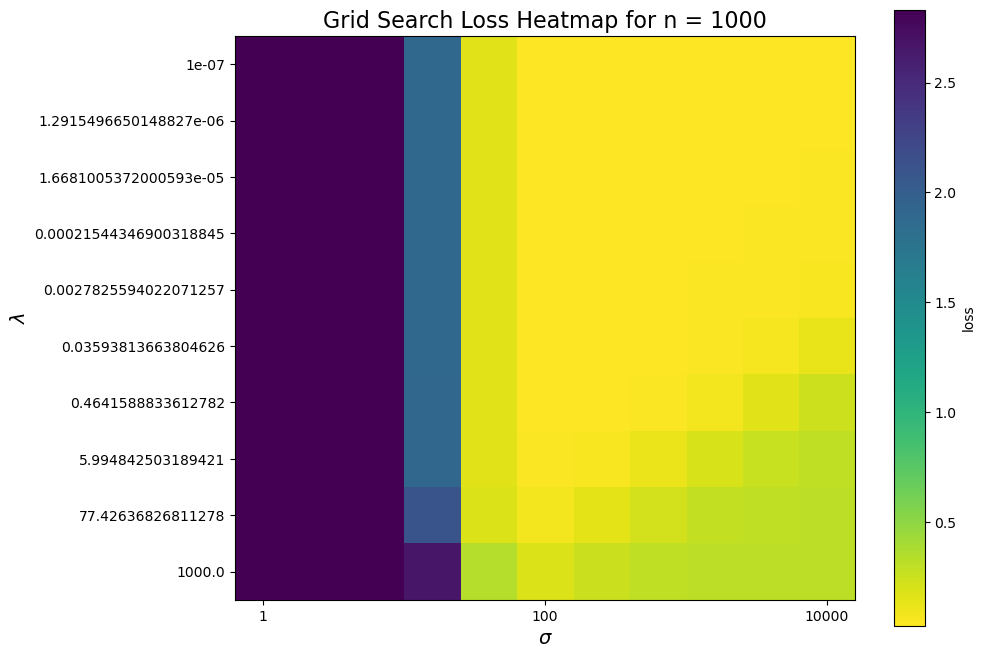

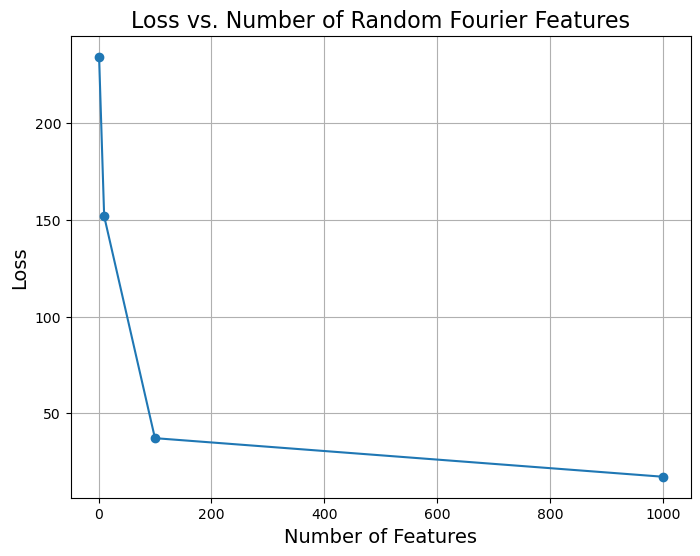

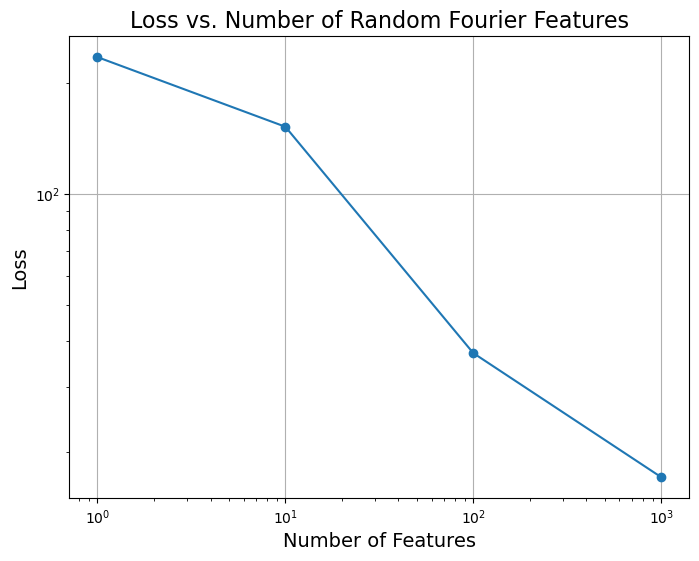

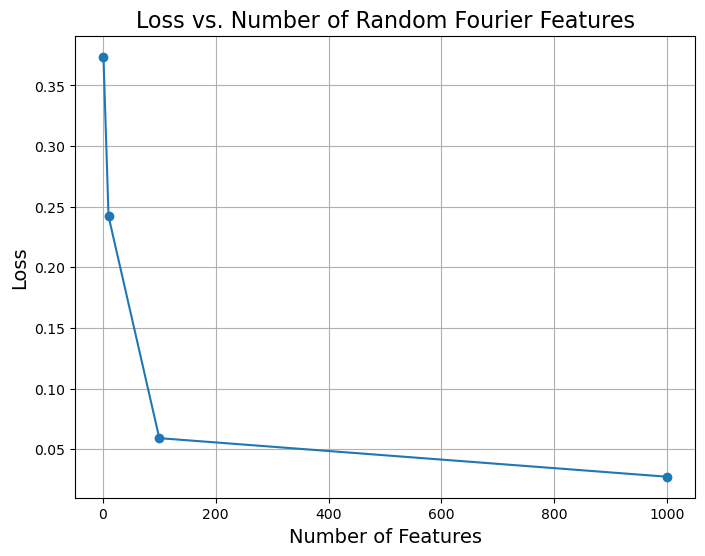

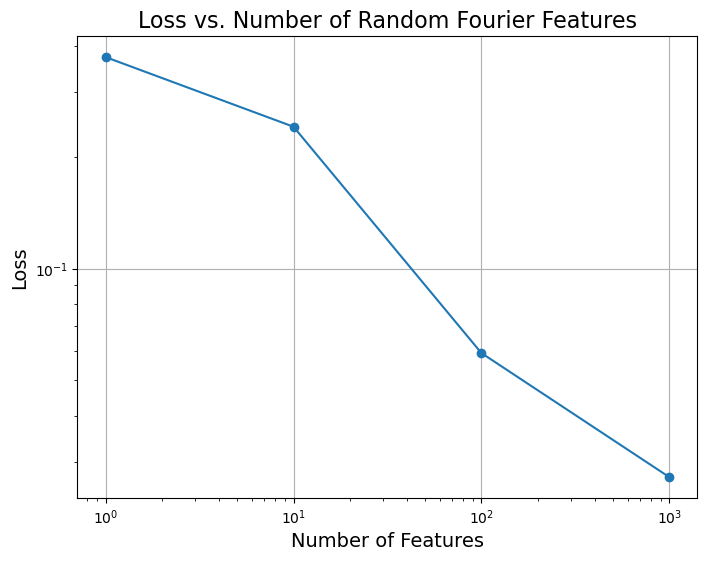

/var/folders/hf/xpg67mrx1vjb7hzv3ym5m07c0000gn/T/ipykernel_57079/2565313103.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


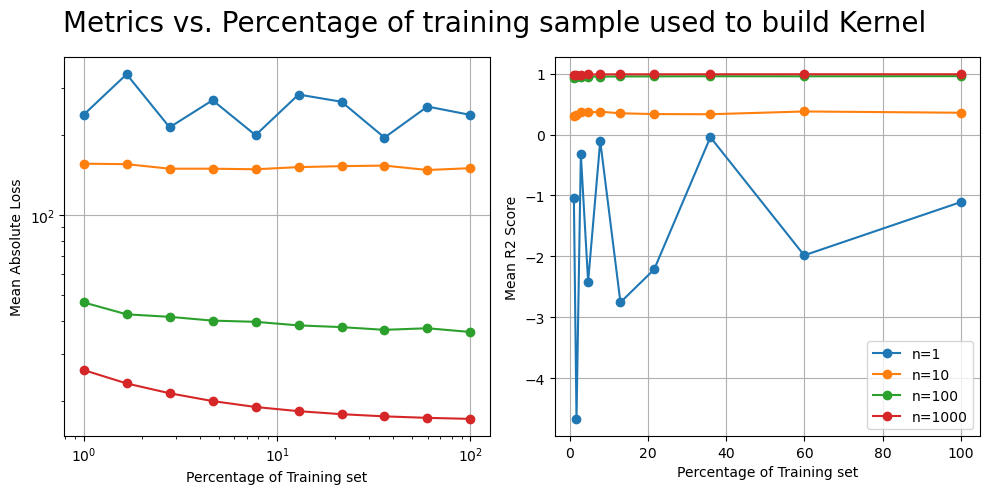

In [76]:
### block to recreate the learning curve and r2-score figure

N = 5
F = 4 # number of feature sweep points
num_lam = 10 
num_sig = 11
cv = 4 # number of K-folds
params = {
        'lambdas':np.logspace(-7, 3, num=num_lam, endpoint=True), 
        'sigmas':np.logspace(0, 4, num=num_sig, endpoint=True)
        }
num_frac = 10 # number of fraction_training experiment

# Declare variables to hold return values
score_matrix = np.full((N, F, num_lam, num_sig), fill_value=np.inf, dtype=np.float32)
best_scores = np.full((N,F), fill_value=np.inf, dtype=np.float32)
best_lambdas = np.full((N,F), fill_value=np.inf, dtype=np.float32)
best_sigmas = np.full((N,F), fill_value=np.inf, dtype=np.float32)
mean_losses = np.full((N,F), fill_value=np.inf, dtype=np.float32)
maes = np.full((N, F, num_frac), np.inf, dtype=np.float32)
r2_scores = np.zeros((N, F, num_frac))
fraction = np.logspace(start=-2, stop=0, num=num_frac, endpoint=True)

for i in tqdm(range(N)):    
    X, X_test, Y, Y_test = train_test_split(features, labels, test_size=0.15, shuffle=True)
    # X = X[:1000]
    # Y = Y[:1000]
    num_features = np.logspace(start=0, stop=3, num=F, endpoint=True, dtype=np.int32)
    print("Grid Search | ", end='')

    score_matrix[i], best_scores[i], best_lambdas[i], best_sigmas[i], _ = GridSearchFeature(X, Y, params, num_features, cv=cv)
    
    
    print("Feature Sweep | ", end='')
    mean_losses[i] = mae_across_feature(X, Y, X_test, Y_test, best_lambdas[i], best_sigmas[i], num_features, cv=cv)
    

    print("Fraction Experiment")
    maes[i], r2_scores[i] = RFF_fraction_experiment(X, Y, X_test, Y_test, best_lambdas[i], best_sigmas[i], num_features, fraction, cv=cv)

# Save results, then average the metrics and return values appropriately
np.savez(
    'feature_sweep_results/hyperparameters.npz', 
    best_scores=best_scores, 
    best_lambdas=best_lambdas, 
    best_sigmas=best_sigmas, 
    num_features=num_features,
    score_matrix = score_matrix
)
score_matrix = score_matrix.mean(axis=0) # average across N iteration
# print(score_matrix.shape)
plot_grid(num_features, score_matrix, params['lambdas'])

mean_losses_converted = mean_losses * 627.5
np.savez('feature_sweep_results/losses.npz', mean_losses=mean_losses, mean_losses_converted=mean_losses_converted) 
mean_losses = mean_losses.mean(0) # average across N iteration
plot_feature_sweep(mean_losses, num_features)

np.savez('krr_fraction_experiment/rff_metrics.npz', maes=maes, r2_scores=r2_scores)
maes = maes.mean(0)
r2_scores = r2_scores.mean(0)
plot_fraction_exp(maes, r2_scores, num_features, fraction)



In [10]:
### Entire Pipeline ###

"""
all_maes = []
for n in range(10):
    shuffle dataset
    maes = []
    for fraction in training_fractions:
        best_params = GridSearch
         preds = KRR(best_params)
        mae = mean(abs(preds-y_test))
        maes.append(mae)
    all_maes.append(maes)
"""

array([186.4796  , 135.073   ,  40.80501 ,  25.630745], dtype=float32)